In [1307]:
import time
import logging
import requests
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
from math import sqrt
from bs4 import BeautifulSoup
from scipy.signal import argrelextrema, savgol_filter
from scipy.stats import linregress
from IPython.display import clear_output
from collections import defaultdict

# utility functions and tests

In [1309]:
def chunker(seq, size):
    return (seq[idx:idx + size] for idx in range(0, len(seq), size))

def get_coef(x1:float, x2:float, y1:float, y2:float) -> tuple:
    # get slope intercept coefs
    slope, intercept, r_value, p_value, std_err = linregress([x1, x2], [y1, y2])
    
    return slope, intercept

def get_line(x1:float, x2:float, slope:float, intercept:float) -> np.array:
    # iterated linear function
    line = list()
    for x in range(x1, x2+1):
        line.append((x, slope * x + intercept))
        
    return np.array(line)

def yfinance_used():
    %pip install yfinance
    %pip install --upgrade numpy==1.21.2
    %pip install --upgrade pandas==1.3.3
    clear_output()
    
    print('yfinance installed')

logging.basicConfig(
    format='%(asctime)s,%(msecs)d %(name)s %(levelname)s: %(message)s',
    datefmt='%H:%M:%S',
    level=logging.INFO,
    handlers=[
        logging.FileHandler("logs.log"),
        logging.StreamHandler()
    ]
)
logger = logging.getLogger()

In [714]:
def test_df_shape(pre_shape: tuple, cols_added: int, post_shape: tuple) -> None:
    try:
        assert pre_shape[0] == post_shape[0]
    except AssertionError as e:
        logger.exception("inconsistent rows value")
        raise e
    try:
        assert post_shape[1] == pre_shape[1] + cols_added
    except AssertionError as e:
        logger.exception("inconsistent columns value")
        raise e

    logger.info("test shape PASSED")

    return None

# GET DATA

## The data for the model include the 2 streams:

i) the numeric data, in particular: 
 
 a) prices and volume for the *target* stock \
 b) prices and volume for the *relative* stocks and numeric values for *financial indicators*
 
ii) the text data, i.e. news, reports, social media posts \
Below are the scripts to describe the collection of this data.

The financial objects that will be basis for the model fit is based on several stocks, financial market indices, raw market indices and currencies.

## i) NUMERIC FEATURES

The model is designed for the timeframes of 1 hour. As the target ticker [Gazprom stock](https://www.gazprom.com/) traded at the Moscow Exchange. The stock is in the top 10 by the trade volume and well covered in the mass media.\
The data provider for the price data is [yahoo finance API package](https://pypi.org/project/yfinance/).

In [1310]:
tickers = {
    'stocks' : ['GAZP.ME', 'SNGSP.ME' , 'ROSN.ME', 'NVTK.ME'], # stocks
    'market_indices' : ['MOEX.ME', '^DJI', '^IXIC', '000001.SS', '^BSESN'], # markets indices
    'raw_market' : ['BZ=F', 'GC=F', 'XW=F'], # raw markets
    'currency' : ['EURUSD=X', 'CNY=X', 'RUB=X'] # currancies
}

# the collection of ticker's instances
my_objects = defaultdict(dict)

In [1325]:
# the constants within a run
DATA_PATH = "data/"
start_date = "2020-08-15"
end_data = "2022-07-02"
series_name = "Close"

For the purpose of integrity the model input of a ticker will be processed within an instance of the class Ticker and then appended to the aggregating dictionary.\
Every data transformation within the class is described based one the model's target stock and Close price:

In [1358]:
class Ticker:
    def __init__(self, ticker_name:str, series_name:str):
        self.ticker_name = ticker_name
        self.data = pd.DataFrame(dtype=object, columns=['Open','High','Low','Close','Adj Close','Volume'])
        self.series_name = series_name
        
    def collect_yf(self, start:str, end:str, interval:str, DATA_PATH:str=DATA_PATH) -> pd.DataFrame: 
        '''download and save locally the data from yahoo finance'''    
        yfinance_used()
        import yfinance as yf
        self.data = pd.concat([
            self.data, 
            yf.download(tickers=self.ticker_name, start=start, end=end, interval=interval)
        ]).rename_axis('Datetime').reset_index(drop=False)       
        self.data.to_parquet(
            DATA_PATH + f"{self.ticker_name}_{start_date}_{end_date}.parquet.gzip", 
            index=False, compression="gzip"
        )
             
        return self.data
    
    def collect_local(self, start:str, end:str, DATA_PATH:str=DATA_PATH):
        '''download the data from the local directory'''
        self.data = pd.read_parquet(DATA_PATH + f'{self.ticker_name}_{start_date}_{end_date}.parquet.gzip')
        
        return self.data

    def adjust_datetime(self):
        '''adjusting the datetime index'''
        
        self.data.Datetime = self.data.Datetime.map(lambda v: datetime.strftime(v, '%Y-%m-%d %H:%M:%S'))
        if sum([self.data.Datetime.apply(lambda v: v.minute).iloc[idx] == 0 for idx in range(2)]) == 2:
            self.data.Datetime += timedelta(minutes=30)
        elif sum([self.data.Datetime.apply(lambda v: v.minute).iloc[idx] == 15 for idx in range(2)]) == 2:
            self.data.Datetime += timedelta(minutes=15)
        elif sum([self.data.Datetime.apply(lambda v: v.minute).iloc[idx] == 30 for idx in range(2)]) == 2:
            self.data.Datetime += timedelta(minutes=0)
        else:
            return 'inconsistent datetime index'
        
    def get_smooth_line(self, poly:int=3, series_name:str=series_name) -> pd.Series:
        # smoothering the timeseries
        period_diff = len(self.data[series_name]) // 30
        period_diff = 1 if period_diff == 0 else period_diff
        smooth = int(2 * period_diff + poly)
        pts = savgol_filter(self.data[series_name], smooth, poly)
        # smoothing time series
        sm_pts = np.array([])
        for chunk in chunker(self.data[series_name], 90):
            sm_pts = np.append(sm_pts, smooth_line(chunk, 3))
        try:
            assert len(self.data[series_name]) - len(sm_pts) == 0
        except AssertionError as e:
            utilities.logger.exception("smoothed series inconsistent")
            raise e

        return pd.Series(sm_pts, index=self.data.index, name='smoothed series')
    
    def get_extrema(self, sm_pts:np.ndarray=None) -> tuple:
        if not sm_pts:
            sm_pts = self.get_smooth_line()
        # get local extrema
        local_min_idx = argrelextrema(sm_pts.values, np.less)
        local_max_idx = argrelextrema(sm_pts.values, np.greater)
        # # drop the 2nd extrema if closer than 2 days
        local_min_idx = np.delete(
            local_min_idx[0], 
            np.argwhere(np.diff(local_min_idx[0]) <= 2) + 1
        )
        local_max_idx = np.delete(
            local_max_idx[0], 
            np.argwhere(np.diff(local_max_idx[0]) <= 2) + 1
        )

        return (local_min_idx, local_max_idx)
    
    def get_support(self, local_min_idx:np.ndarray=None) -> pd.Series:
        if not local_min_idx:
            local_min_idx, _ = self.get_extrema()
        sm_pts = self.get_smooth_line()
        support_line = list()
        for i in range(len(local_min_idx)-1):
            support_line.append(get_line(
                local_min_idx[i], local_min_idx[i+1], 
                *get_coef(local_min_idx[i], local_min_idx[i+1], sm_pts[local_min_idx[i]], sm_pts[local_min_idx[i+1]])
            )[:-1])
        support_line = np.array([x for sl in support_line for x in sl])
        # extrapolation due to the absence of extrema for the last day
        support_line = np.concatenate((
            support_line,
            get_line(
                local_min_idx[-1], sm_pts.index[-1], 
                *get_coef(local_min_idx[-1], sm_pts.index[-1], sm_pts[local_min_idx[-1]], sm_pts.values[-1])
                )
        ))       
        # empty start fill up
        support_line = np.concatenate((
            np.array(list(zip(
                np.array(range(int(support_line[0][0]))),
                np.zeros(int(support_line[0][0]), dtype=int)
            ))),
            support_line))   
                
        return pd.Series(support_line[:,1], index=support_line[:,0].astype(int), name='support')

    def get_resistance(self, local_max_idx:np.ndarray=None) -> pd.Series:
        if not local_max_idx:
            _, local_max_idx = self.get_extrema()
        sm_pts = self.get_smooth_line()
        resistance_line = list()
        for i in range(len(local_max_idx)-1):
            resistance_line.append(get_line(
                local_max_idx[i], local_max_idx[i+1], 
                *get_coef(local_max_idx[i], local_max_idx[i+1], sm_pts[local_max_idx[i]], sm_pts[local_max_idx[i+1]])
            ))
        # extrapolation due to the absence of extrema for the last day
        resistance_line.append(get_line(
            local_max_idx[-1], sm_pts.index[-1], 
            *get_coef(local_max_idx[-1], sm_pts.index[-1], sm_pts[local_max_idx[-1]], sm_pts.values[-1])
        ))
        resistance_line = np.array([x for sl in resistance_line for x in sl])
        # empty start fill up
        resistance_line = np.concatenate((
            np.array(list(zip(
                np.array(range(int(resistance_line[0][0]))),
                np.zeros(int(resistance_line[0][0]), dtype=int)
            ))),
            resistance_line))   
                
        return pd.Series(resistance_line[:,1], index=resistance_line[:,0].astype(int), name='resistance')
    
    def add_resistance_support(self) -> pd.DataFrame:
        sh = self.data.shape
        self.data = pd.concat([
            self.data, 
            self.get_support(),
            self.get_resistance()
        ],axis=1) 
        test_df_shape(sh, 2, self.data.shape)
        logger.info(f"resistance and support lines for {self.ticker_name} {series_name} added")
        
        return self.data
    
    def get_moving_average(self, n_period:int, series_name:str=series_name) -> pd.DataFrame:
        sh = self.data.shape
        for i in range(n_period, len(self.data)):
            self.data.loc[self.data.index == self.data.iloc[i-n_period:i].index[-1], f'moving_average_{series_name}_{n_period}'] =\
                self.data.iloc[i-n_period:i+n_period][series_name].mean()
        test_df_shape(sh, 1, self.data.shape)
        logger.info(f"moving average of {n_period} for {self.ticker_name} {series_name} added")
              
        return self.data
    
    def get_stochastic_oscillator(self, n_period:int, series_name:str=series_name) -> pd.DataFrame:
        sh = self.data.shape
        self.data[f"oscillator_{series_name}"] = 0
        for i in range(n_period ,len(self.data)):
            c = self.data.iloc[i-period:i+period][series_name].values[-1]
            h = self.data.iloc[i-period:i+period][price].max()
            l = self.data.iloc[i-period:i+period][price].min()
            self.sata.loc[slef.data.index == self.data.iloc[i-period:i].index[-1], f"oscillator_{series_name}"] = (c-l) / (h-l)
        test_df_shape(sh, 1, self.data.shape)
        
        logger.info(f"stochastic oscillator for {self.ticker_name} {series_name} added")

In [1339]:
datetime.strftime(data.Datetime[0], '%Y-%m-%d %H:%M:%S')

'2020-08-17 09:30:00'

In [1360]:
data = my_objects[ticker_name].data
data.Datetime = data.Datetime.map(lambda v: datetime.strptime(v, '%Y-%m-%d %H:%M:%S'))

In [ ]:
if sum([self.data.Datetime.apply(lambda v: v.minute).iloc[idx] == 0 for idx in range(2)]) == 2:
    self.data.Datetime += timedelta(minutes=30)

In [ ]:
my_objects[ticker_name] = Ticker(ticker_name, series_name)
my_objects[ticker_name].collect_local(start_date, end_date)
my_objects[ticker_name].adjust_datetime()

In [1355]:
sum([data.Datetime.apply(lambda v: v.minute).iloc[0] == 0 for idx in range(2)]) 

0

In [ ]:
    def adjust_datetime(self):
        '''adjusting the datetime index'''
        
        self.data.Datetime = self.data.Datetime.map(lambda v: datetime.strptime(v[:-6], '%Y-%m-%d %H:%M:%S'))
        if sum([self.data.Datetime.apply(lambda v: v.minute).iloc[idx] == 0 for idx in range(2)]) == 2:
            self.data.Datetime += timedelta(minutes=30)
        elif sum([self.data.Datetime.apply(lambda v: v.minute).iloc[idx] == 15 for idx in range(2)]) == 2:
            self.data.Datetime += timedelta(minutes=15)
        elif sum([self.data.Datetime.apply(lambda v: v.minute).iloc[idx] == 30 for idx in range(2)]) == 2:
            self.data.Datetime += timedelta(minutes=0)
        else:
            return 'inconsistent datetime index'

## PROCESS NUMERIC FEATURES

(1) Initiate an instance:

In [1327]:
ticker_name = tickers['stocks'][0]
my_objects[ticker_name] = Ticker(ticker_name, series_name)

print(f'the ticker name : {my_objects[ticker_name].ticker_name}')
print(f'the data within : {my_objects[ticker_name].data}')

the ticker name : GAZP.ME
the data within : Empty DataFrame
Columns: [Open, High, Low, Close, Adj Close, Volume]
Index: []


(2.a) Get the data from y_finance with the method <ins>*collect_yf*</ins> :

In [1328]:
my_objects[ticker_name] = Ticker(ticker_name, series_name)
my_objects[ticker_name].collect_yf(start_date, end_date, '60m')

print(f'\nthe data within :\n{my_objects[ticker_name].data.head(2)}')

yfinance installed
[*********************100%***********************]  1 of 1 completed

the data within :
                   Datetime        Open        High         Low       Close  \
0 2020-08-17 09:30:00+03:00  193.830002  194.399994  192.639999  194.309998   
1 2020-08-17 10:30:00+03:00  194.289993  194.679993  193.399994  194.039993   

    Adj Close    Volume  
0  194.309998  14158600  
1  194.039993   9422020  


(2.b) In case the saved data is uploaded from the local db the method <ins>*collect_local*</ins> is called:

In [1332]:
my_objects[ticker_name] = Ticker(ticker_name, series_name)
my_objects[ticker_name].collect_local(start_date, end_date)

print(f'\nthe data within :\n{my_objects[ticker_name].data.head(2)}')


the data within :
                   Datetime        Open        High         Low       Close  \
0 2020-08-17 09:30:00+03:00  193.830002  194.399994  192.639999  194.309998   
1 2020-08-17 10:30:00+03:00  194.289993  194.679993  193.399994  194.039993   

    Adj Close    Volume  
0  194.309998  14158600  
1  194.039993   9422020  


To make the data processing more convinient the date and time ticks set as index and converted from string to datetime format. The starting points of the time series might differ (e.g. 9:00 vs 9:15 vs 9:30 in target series). To adjust that all the series different from the target they are moved forward. Considering the model's timeframe is a day this alteration is unlikely to cause significant deflection

In [1359]:
my_objects[ticker_name] = Ticker(ticker_name, series_name)
my_objects[ticker_name].collect_local(start_date, end_date)
my_objects[ticker_name].adjust_datetime()

AttributeError: 'str' object has no attribute 'minute'

The next step is to enrich the features based on the available timeseries. Thus the following technical indicators are added:

(3.a) [resistance and support lines](https://www.investopedia.com/trading/support-and-resistance-basics/) : basically the resistance / support lines for the current period are the lines between the previous highest / lowest price and following further with the slope. The update on my side is that the period between the local extrema should be more than 2 \
(3.b) [moving average](https://www.investopedia.com/terms/m/movingaverage.asp) : simple means of the series for the predefined periods of 4 and 8 hours \
(3.c) [stochastic oscillator](https://www.investopedia.com/terms/s/stochasticoscillator.asp) : momentum indicator comparing a particular closing price of a security to a range of its prices over a certain period of time (8 hours)

#### (3.a) resistance | support lines

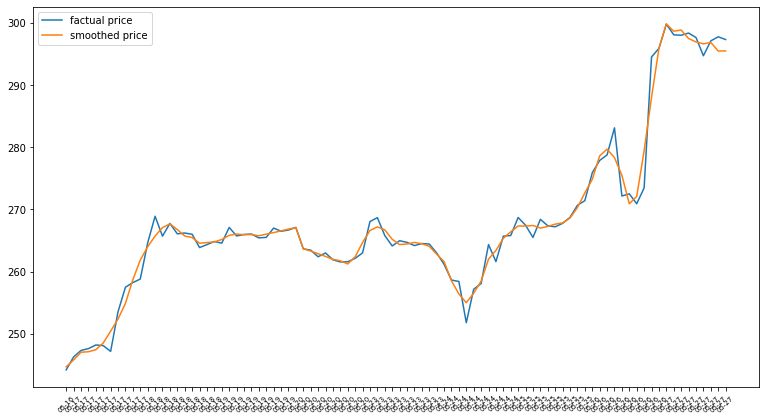

In [1258]:
my_objects[ticker_name] = Ticker(ticker_name)
my_objects[ticker_name].collect_local(start_date, end_date)
my_objects[ticker_name].adjust_datetime()

# plotting example
date_ticks = list(my_objects[ticker_name].data.Datetime.map(lambda v: datetime.strftime(v, '%m-%d')))
n, period = 22, (n, n+90)
plt.figure(figsize=(13, 7))
plt.plot(my_objects[ticker_name].data.Close[period[0]:period[1]], label = 'factual price')
plt.plot(range(period[0], period[1]),sm_pts[period[0]:period[1]], label = 'smoothed price')
plt.xticks(range(period[0], period[1]), date_ticks[period[0]:period[1]], rotation=45, fontsize=7)
plt.legend();

The values of the local minimum | maximum prices can be either obtained by the derivatives calculation or applying the existing functions like [agrelextrema](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.argrelextrema.html) from scipy. If the distance between neigbouring extrema is too low the resitance | support lines might be inefficient, thus the minimum distance is defined as more than 2 periods:

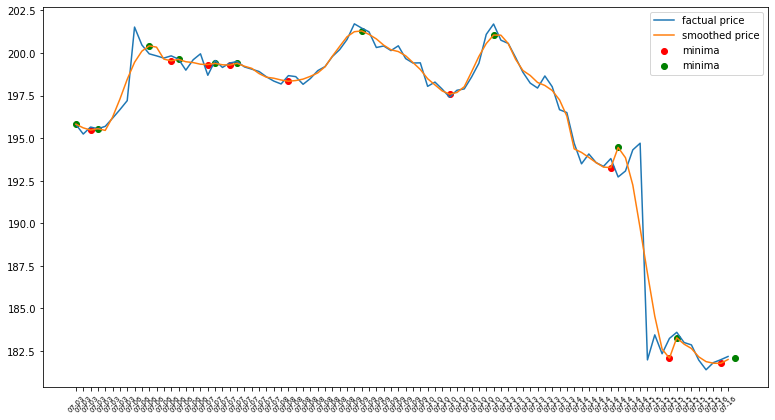

In [1259]:
my_objects[ticker_name] = Ticker(ticker_name)
my_objects[ticker_name].collect_local(start_date, end_date)
my_objects[ticker_name].adjust_datetime()
sm_pts = my_objects[ticker_name].get_smooth_line()
local_min_idx, local_max_idx = my_objects[ticker_name].get_extrema()

# plotting example
date_ticks = list(my_objects[ticker_name].data.Datetime.map(lambda v: datetime.strftime(v, '%m-%d')))
n, period = 22, (n, n+90)
plt.figure(figsize=(13, 7))
plt.plot(my_objects[ticker_name].data.Close[period[0]:period[1]], label = 'factual price')
plt.plot(range(period[0], period[1]),sm_pts[period[0]:period[1]], label = 'smoothed price')
plt.scatter(
    local_min_idx[(local_min_idx >= period[0]) & (local_min_idx <= period[1])], 
    sm_pts[local_min_idx[(local_min_idx >= period[0]) & (local_min_idx <= period[1])]], 
    color='r', label='minima'
)
plt.scatter(
    local_max_idx[(local_max_idx >= period[0]) & (local_max_idx <= period[1])], 
    sm_pts[local_max_idx[(local_max_idx >= period[0]) & (local_max_idx <= period[1])]], 
    color='g', label='minima'
)
plt.xticks(range(period[0], period[1]), date_ticks[period[0]:period[1]], rotation=45, fontsize=7)
plt.legend();

The final step is to get the lines between the neigbour local extrema^

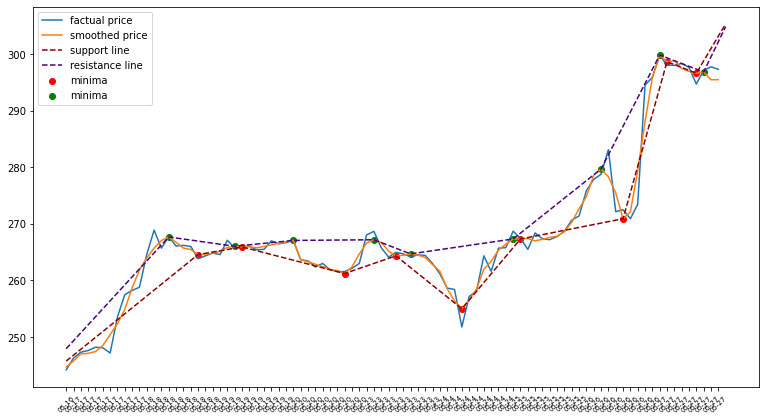

In [1261]:
my_objects[ticker_name] = Ticker(ticker_name)
my_objects[ticker_name].collect_local(start_date, end_date)
my_objects[ticker_name].adjust_datetime()
sm_pts = my_objects[ticker_name].get_smooth_line()
local_min_idx, local_max_idx = my_objects[ticker_name].get_extrema()
support_line = my_objects[ticker_name].get_support()
resistance_line = my_objects[ticker_name].get_resistance()

# plotting example
date_ticks = list(my_objects[ticker_name].data.Datetime.map(lambda v: datetime.strftime(v, '%m-%d')))
n, period = 3012-90, (n, n+90)
plt.figure(figsize=(13, 7))
plt.plot(my_objects[ticker_name].data.Close[period[0]:period[1]], label = 'factual price')
plt.plot(range(period[0], period[1]),sm_pts[period[0]:period[1]], label = 'smoothed price')
plt.scatter(
    local_min_idx[(local_min_idx >= period[0]) & (local_min_idx <= period[1])], 
    sm_pts[local_min_idx[(local_min_idx >= period[0]) & (local_min_idx <= period[1])]], 
    color='r', label='minima'
)
plt.scatter(
    local_max_idx[(local_max_idx >= period[0]) & (local_max_idx <= period[1])], 
    sm_pts[local_max_idx[(local_max_idx >= period[0]) & (local_max_idx <= period[1])]], 
    color='g', label='minima'
)
plt.plot(
    support_line.loc[period[0]:period[1]].index,
    support_line.loc[period[0]:period[1]].values,
    color = 'darkred',
    label = 'support line',
    linestyle = '--'
)
plt.plot(
    resistance_line.loc[period[0]:period[1]].index,
    resistance_line.loc[period[0]:period[1]].values,
    color = 'indigo',
    label = 'resistance line',
    linestyle = '--'
)
plt.xticks(range(period[0], period[1]), date_ticks[period[0]:period[1]], rotation=45, fontsize=7)
plt.legend();

The final sub-step is to add the lines as the features to the dataframe data:

#### (3b) moving average 

In [ ]:
n_period = 4 
series_name = 'Close'

series = 

for i in range(period, len(self.data)):
    self.data.loc[self.data.index == self.data.iloc[i-n_period:i].index[-1], f'moving_average_{series_name}_{n_period}'] = self.data.iloc[i-n_period:i+n_period][series_name].mean()
test_df_shape(sh, 1, df.shape)
print(f"moving average of {period} added")
              
        return self.data

In [1306]:
my_objects[ticker_name] = Ticker(ticker_name)
my_objects[ticker_name].collect_local(start_date, end_date)
my_objects[ticker_name].adjust_datetime()

ma_4 = my_objects[ticker_name].get_moving_average(4, 'Close')
ma_8 = my_objects[ticker_name].get_moving_average(8, 'Close')

moving average of 4 added
moving average of 8 added


The additional calculation will be the [stochastic oscillator](https://www.investopedia.com/terms/s/stochasticoscillator.asp) . The indicator compares the current price to the prices within the defined period in the past.

In [497]:
def add_stoch_oscil(df, price):
    start_time = time.time()
    period = 14
    df['stoch_oscil'] = 0
    for i in range(period, len(df)):
        c = df.iloc[i-period:i+period][price].values[-1]
        h14 = df.iloc[i-period:i+period][price].max()
        l14 = df.iloc[i-period:i+period][price].min()
        df.loc[df.index == df.iloc[i-period:i].index[-1], f'stoch_oscil_{price}'] = (c - l14) / (h14 - l14)
        
    print(f'stochastic oscilator added, time {round(time.time() - start_time, 2)}')

    return df

add_stoch_oscil(df, 'Close_GAZP.ME')

moving average added, time 3.13


,Datetime,Open_GAZP.ME,High_GAZP.ME,Low_GAZP.ME,Close_GAZP.ME,Adj Close_GAZP.ME,Volume_GAZP.ME,Dividends,moving_average_4,moving_average_8,stoch_oscil,stoch_oscil_Close_GAZP.ME
0,2020-04-27 09:30:00,186.529999,187.380005,186.289993,186.410004,186.410004,3277800,0.0,NaN,NaN,0,NaN
1,2020-04-27 10:30:00,186.419998,188.080002,186.190002,187.389999,187.389999,6242660,0.0,NaN,NaN,0,NaN
2,2020-04-27 11:30:00,187.410004,188.470001,187.410004,187.600006,187.600006,4135940,0.0,NaN,NaN,0,NaN
3,2020-04-27 12:30:00,187.619995,188.339996,187.070007,187.080002,187.080002,4553560,0.0,186.943750,NaN,0,NaN
4,2020-04-27 13:30:00,187.110001,187.440002,186.919998,187.339996,187.339996,2813540,0.0,187.023750,NaN,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
4635,2022-04-06 15:30:00,244.669998,246.490005,243.740005,245.460007,245.460007,1472640,0.0,243.043753,243.414168,0,0.160048
4636,2022-04-06 16:30:00,245.589996,245.589996,243.509995,244.710007,244.710007,917480,0.0,242.787146,243.406365,0,0.160048
4637,2022-04-06 17:30:00,244.710007,244.759995,239.210007,239.990005,239.990005,2715490,0.0,242.595004,243.566002,0,0.160048
4638,2022-04-06 18:30:00,239.990005,240.000000,239.699997,239.699997,239.699997,0,0.0,242.186005,243.548891,0,0.173639


To wrap up the indicators are applied to all close prices of the tickers:

In [522]:
for ticker in tickers['all']:    
    add_moving_average(4, df_agg[ticker], f'Close_{ticker}')
    add_moving_average(8, df_agg[ticker], f'Close_{ticker}')
    add_stoch_oscil(df_agg[ticker], f'Close_{ticker}')

moving average added, time 2.53
moving average added, time 2.59
moving average added, time 4.0
moving average added, time 2.58
moving average added, time 2.59
moving average added, time 3.97
moving average added, time 2.6
moving average added, time 2.6
moving average added, time 3.89
moving average added, time 2.61


KeyboardInterrupt: 

In [ ]:
x = df.drop('Close', axis=1).copy()
print(x.shape)
y = df.Close
xScaler, yScaler = MinMaxScaler((0,1)), MinMaxScaler((0,1))
xSc, ySc = xScaler.fit_transform(x), yScaler.fit_transform(y.values.reshape(-1, 1))

print([x.shape, xSc.shape], [y.shape, ySc.shape])

xTr = xSc[:len(df[df.index.strftime('%Y-%m-%d') <= d])]
xTs = xSc[len(df[df.index.strftime('%Y-%m-%d') <= d]):]
yTr = ySc[:len(df[df.index.strftime('%Y-%m-%d') <= d])]
yTs = ySc[len(df[df.index.strftime('%Y-%m-%d') <= d]):]

# TEXT FEATURES

In [ ]:
yf.Ticker(tickers['all'][0]).news

In [ ]:
# init container
text_container = dict()

## FINAM

In [ ]:
def from_finam(company):
    finam_url = f'https://www.finam.ru/profile/moex-akcii/{company}/analytics/'
    page = requests.get(finam_url)
    soup = BeautifulSoup(page.text, 'html.parser')

    finam_news = {}
    for news, date in zip(
        [nw.parent.text for nw in soup.findAll(class_="ReviewNote__reviewTitle--1lt")],
        [d.find(target="_blank").text for d in soup.findAll(class_="ReviewNote__reviewDate--3sf")]):
        finam_news[date] = news
        
    return finam_news

finam_news = from_finam('gazprom')

# convert dates to timedelta
for k, v in finam_news.items():
    text_container[datetime.strptime(k, '%d.%m.%Y %H:%M')] = v

## BCS

In [ ]:
def from_bcs(company):
    url = f'https://bcs-express.ru/search?q={company}'
    
    page = requests.get(url)
    soup = BeautifulSoup(page.text, 'html.parser')
    
    bcs_news = {}
    for news, date in zip(
        [nw.text for nw in soup.findAll(class_="search-result__item")],
        [d.text for d in soup.findAll(class_="search-result__item-date")]):
        bcs_news[date] = news

    return bcs_news

bcs_news = from_bcs('газпром')

In [ ]:
ru_month = {
    'января' : '01', 'февраля' : '02', 'марта' : '03', 'апреля' : '04',
    'мая' : '05', 'июня' : '06', 'июля' : '07', 'августа' : '08',
    'сентябрря' : '09', 'октября' : '10', 'ноября' : '11', 'декабря' : '12',
}

In [ ]:
ru_month[list(bcs_news.keys())[0].split(' ')[1]]

In [ ]:
' '.join(list(bcs_news.keys())[0].split(' '))

In [ ]:
# convert dates to timedelta
for k, v in finam_news.items():
    k = k.split(' ')
    k[1] = ru_month[k[1]]
    d = datetime.strptime(' '.join(k), '%d %m %Y, %H:%M')
    text_container[d] = v

## TINK

In [ ]:
company = 'GAZP'
url = f'https://www.tinkoff.ru/invest/stocks/{company}/news/'

In [ ]:
page = requests.get(url)
soup = BeautifulSoup(page.text, 'html.parser')

In [ ]:
tink_news = {}
for news, date in zip(
    [nw.text for nw in soup.find_all(class_='NewsItem__announce_vW9LX')],
    [d.text for d in soup.find_all(attrs={'class':'NewsItem__footer_Nh5KD', 'data-qa-file':"NewsItem"})]):
    tink_news[date] = news
    
tink_news

## RECOMMENDATIONS

In [ ]:
company = 'GAZP'
url = f'https://www.tinkoff.ru/invest/stocks/{company}/news/'

## NEWS API

To get the news on the ticker I shall use the open-source API - [NewsAPI](https://github.com/mattlisiv/newsapi-python). Quite easy and fast to deploy, all you need is:

1. install the lib via ``` pip install newsapi-python ```

2. [get the API key](https://newsapi.org/register)

In [ ]:
!pip install newsapi-python
clear_output()

In [ ]:
# get token
token = 'newsapi_token.txt'
token = from_s3(token).read().decode('UTF-8')

# init client
newsapi = NewsApiClient(api_key = token)

All is ready to get the news. Free newsapi plan allows only to get the news 1 month back but that should be sufficient.

In [ ]:
en_articles = newsapi.get_everything(
    q = 'gazprom',
    from_param = '2021-12-02',
    language = 'en',
    sort_by = 'relevancy'
)

len(en_articles['articles'])

In [ ]:
en_articles

Since the company under the ticker is based in the Russian Federation I want to get фдыщ the news in Russian, thus I filter the respective sources:

In [ ]:
# get sources in Russian
rus_sources = []
for s in newsapi.get_sources()['sources']:
    if s['language'] == 'ru':
        rus_sources.append(s['name'])
print(rus_sources)

In [ ]:
ru_articles = newsapi.get_everything(
    q = 'газпром',
    sources = str(rus_sources)[1:-1].replace("'", ""),
    from_param = '2021-12-02',
    language = 'ru',
    sort_by = 'relevancy'
)

len(ru_articles['articles'])